In [23]:
import numpy as np
import seaborn as sns
import os
import itertools
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from ATLAS_data.effFunctions import eventEff,vertexEff,functions_event_eff,functions_vertex_eff
from atlas_susy_2016_08_Recast import (getLLPs, getJets, eventAcc, 
                                       vertexAcc, getModelDict)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution

delphesDir = os.path.abspath("../DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['YlGnBu_r']

### ATLAS data

In [2]:
# data_obs = np.genfromtxt('./ATLAS_data/HEPData-ins1630632-v2-csv/Table5.csv',
#                          delimiter=',',skip_header=11,skip_footer=278)
# data_exp = np.genfromtxt('./ATLAS_data/HEPData-ins1630632-v2-csv/Table5.csv',
#                          delimiter=',',skip_header=291)

data_obs = np.genfromtxt('./ATLAS_data/HEPData-ins1630632-v2-csv/Table6.csv',
                         delimiter=',',skip_header=11,skip_footer=113)
data_exp = np.genfromtxt('./ATLAS_data/HEPData-ins1630632-v2-csv/Table6.csv',
                         delimiter=',',skip_header=126)

### Recast Data

In [3]:
# inputFile = './validation/pp2GoGo_Fig7/Events/run_02/gluino_1400_100.0_tau_1e+00_delphes_events.root'
inputFile = '../eventData/pp2BB1j_atlas_scan/Events/run_33/cdfo_725_700.0_tau_9e-02_delphes_events.root'
modelDict = getModelDict(inputFile,model='sbottom')

mLLP =  725.0
width (GeV) =  7.743529e-15
tau (ns) =  0.08500000451990301


### Get vertex distribution and efficiencies

In [11]:
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()
ntotal = 0
totalweightPB = 0.0
lumi = 32.8
mDV_nTracks_weights = []
mDVcut = 5.0
for ievt in range(nevts):    
   
    ntotal += 1
    tree.GetEntry(ievt)   
    weightPB = tree.Weight.At(1).Weight     
    totalweightPB += weightPB
    ns = weightPB*1e3*lumi # number of signal events

    
    jets = getJets(tree.GenJet,pTmin=25.,etaMax=5.0)
    met = tree.GenMissingET.At(0).MET
    
     # Event acceptance
    evt_acc = eventAcc(jets,met,metCut=200.0,
                               maxJetChargedPT=5.0,minJetPt1=70.,
                               minJetPt2=25.)

    if (not evt_acc): continue
    ns = ns*evt_acc

    llps = getLLPs(tree.bsm,tree.bsmDirectDaughters,tree.bsmFinalDaughters)
    # Vertex acceptances:
    v_acc = np.array([vertexAcc(llp,Rmax=300.0,zmax=300.0,Rmin=4.0,
                                        d0min=2.0,nmin=5,mDVmin=mDVcut)  for llp in llps])

    good_llps = np.array(llps)[v_acc > 0.0]
    if len(good_llps) == 0:
        continue
    # Event efficiency
    evt_eff = eventEff(met,good_llps)
    ns = ns*evt_eff
    # Vertex efficiencies:
    v_eff_near = np.array([vertexEff(llp,strategy='nearest') for llp in llps])
    v_eff_avg = np.array([vertexEff(llp,strategy='average') for llp in llps])

    for illp,llp in enumerate(llps):
        wv_near = v_acc[illp]*v_eff_near[illp]
        wv_avg = v_acc[illp]*v_eff_avg[illp]
        if wv_near*wv_avg > 0.:            
            mDV_nTracks_weights.append([llp.mDV,llp.nTracks,ns*wv_near,ns*wv_avg])

f.Close()

In [13]:
mDV_nTracks_weights = np.array(mDV_nTracks_weights)

/tmp/ipykernel_17151/130779181.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


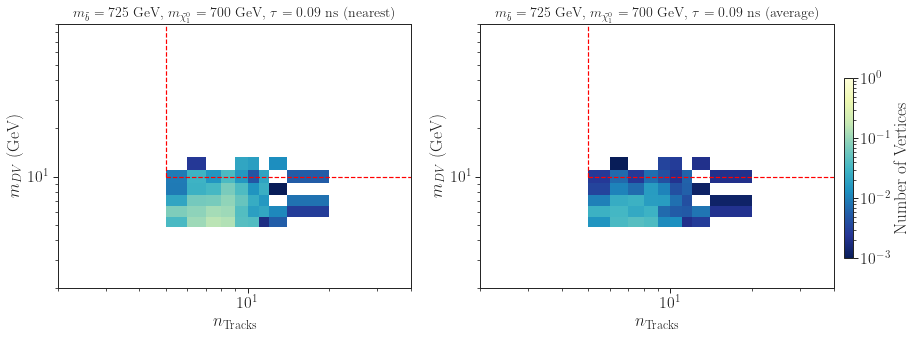

In [17]:
fig,axarr = plt.subplots(nrows=1,ncols=2,figsize=(12,5))

mDV_bins = np.sort(np.unique(data_exp[:,1]))
n_bins = np.sort((np.unique(data_exp[:,0])))
n_bins = np.append(np.unique(data_exp[:,0]),[20.,30.,40.])

labels = ['nearest','average']
for i,label in enumerate(labels):
    h = axarr[i].hist2d(mDV_nTracks_weights[:,1],mDV_nTracks_weights[:,0],cmap=cm,
               weights=mDV_nTracks_weights[:,2+i],bins=(n_bins,mDV_bins),norm=LogNorm(vmin=1e-3,vmax=1))

    
    axarr[i].hlines(y=10.0,xmin=5.,xmax=max(n_bins),colors='red',linestyle='dashed')
    axarr[i].vlines(x=5.0,ymin=10.,ymax=max(mDV_bins),colors='red',linestyle='dashed')
    axarr[i].set_xscale('log')
    axarr[i].set_yscale('log')
    axarr[i].set_ylabel(r'$m_{DV}$ (GeV)')
    axarr[i].set_xlabel(r'$n_{\rm Tracks}$')
    axarr[i].set_ylim(2,mDV_bins.max())
    axarr[i].set_xlim(2,40)
    axarr[i].set_title(r'$m_{\tilde b} = %1.0f$ GeV, $m_{\tilde \chi_1^0} = %1.0f$ GeV, $\tau = %1.2f$ ns (%s)' 
          %(modelDict['mLLP'],modelDict['mLSP'],modelDict['tau_ns'],label),fontsize=14)

    
fig.subplots_adjust(right=0.9,top=1.1)
cbar_ax = fig.add_axes([0.99, 0.25, 0.01, 0.5]) 
fig.colorbar(h[3],label='Number of Vertices',cax=cbar_ax)
plt.tight_layout()
plt.show()    

## Plot Efficiencies for each scenario

In [29]:
rVals = [20.,23.,27.,35.,42.,50.,83.,110.,115.,121.,170.,200.]
mDVvals = np.logspace(0.,3.5,100)
nVals = np.logspace(0.,2.5,100)
rVals = rVals[:4]

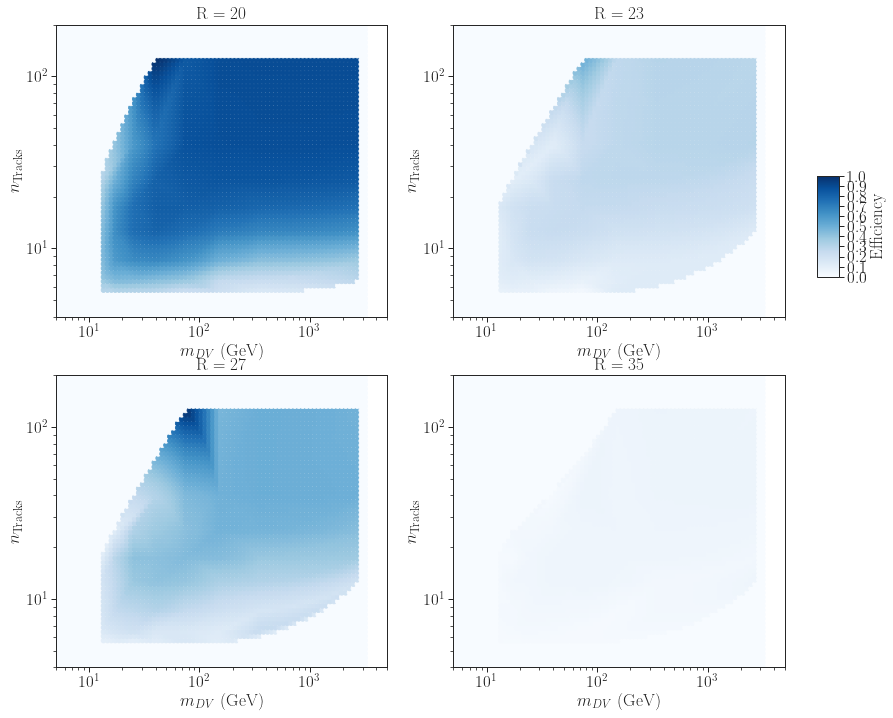

In [31]:
fig,axarr = plt.subplots(nrows=int(len(rVals)/2),ncols=2,figsize=(15,7))
# cm = sns.color_palette("viridis", as_cmap=True,N=len(np.arange(0.,1.1,0.1)))
cm = plt.colormaps["Blues"]
for ir,r in enumerate(rVals):
    ax = axarr[int(ir/2),np.mod(ir,2)]
    # Select eff function
    eff_F = [f for Rint,f in functions_vertex_eff.items() 
                if Rint[0] < r <= Rint[1]]
    if not eff_F:
        continue
    else:
        eff_F = eff_F[0]['bounds']
    eff = np.array([[mDV,n,eff_F(mDV,n)] for (mDV,n) in itertools.product(mDVvals,nVals)])
    p = ax.scatter(eff[:,0],eff[:,1],c=eff[:,2],cmap=cm,vmin=0.,vmax=1.0)
    ax.set_title(r'R = %1.0f' %(r))
    ax.set_xlabel(r'$m_{DV}$ (GeV)')
    ax.set_ylabel(r'$n_{\rm Tracks}$')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(5.,5000.)
    ax.set_ylim(4,200.)
    # plt.colorbar(label='Efficiency')

fig.subplots_adjust(right=0.8,top=1.4)
cbar_ax = fig.add_axes([0.83, 0.9, 0.02, 0.2])
# fig.colorbar(r, cax=cbar_ax)    
fig.colorbar(p,label='Efficiency',cax=cbar_ax,ticks=np.arange(0.,1.1,0.1))
# plt.tight_layout()
plt.show()

In [ ]:
fig,axarr = plt.subplots(nrows=int(len(rVals)/2),ncols=2,figsize=(15,7))
# cm = sns.color_palette("viridis", as_cmap=True,N=len(np.arange(0.,1.1,0.1)))
cm = plt.colormaps["Blues"]
for ir,r in enumerate(rVals):
    ax = axarr[int(ir/2),np.mod(ir,2)]
    # Select eff function
    eff_F = [f for Rint,f in functions_vertex_eff.items() 
                if Rint[0] < r <= Rint[1]]
    if not eff_F:
        continue
    else:
        eff_F = eff_F[0]['bounds']
    eff = np.array([[mDV,n,eff_F(mDV,n)] for (mDV,n) in itertools.product(mDVvals,nVals)])
    p = ax.scatter(eff[:,0],eff[:,1],c=eff[:,2],cmap=cm,vmin=0.,vmax=1.0)
    ax.set_title(r'R = %1.0f' %(r))
    ax.set_xlabel(r'$m_{DV}$ (GeV)')
    ax.set_ylabel(r'$n_{\rm Tracks}$')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(5.,5000.)
    ax.set_ylim(4,200.)
    # plt.colorbar(label='Efficiency')

fig.subplots_adjust(right=0.8,top=1.4)
cbar_ax = fig.add_axes([0.83, 0.9, 0.02, 0.2])
# fig.colorbar(r, cax=cbar_ax)    
fig.colorbar(p,label='Efficiency',cax=cbar_ax,ticks=np.arange(0.,1.1,0.1))
# plt.tight_layout()
plt.show()